In [106]:
import requests
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.utils import resample
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor


In [107]:
# скачаємо файл
URL = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv'

req = requests.get(URL)



In [108]:
#Перевірка на статус код
def check_status_code(req) -> bool:
    match req.status_code:
        case 200:
            print('All okey')
        case 404:
            raise Exception('Page not found')
        case _ as e:
            print(f'Something wrong : {e}')
check_status_code(req)

All okey


In [109]:
df_ikea = pd.read_csv(URL)

In [110]:

#Step 1: EDA - shape, head, tail, sample, info

#Аналізуємо набір данних магазину IKEA
#На першому кроці аналізуємо та описуємо набір
#Він має 3694 рядки та 14 стовпців

df_ikea.shape

(3694, 14)

In [111]:
df_ikea.head()

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


In [112]:
df_ikea.tail()

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
3689,3689,99157902,ELVARLI,Wardrobes,750.0,SR 820,True,https://www.ikea.com/sa/en/p/elvarli-1-section...,No,"1 section, 92x51x222-350 cm",Ehlén Johansson,50.0,NaN,91.0
3690,3690,9158152,ELVARLI,Wardrobes,1572.0,"SR 1,755",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 135x51x222-350 cm",Ehlén Johansson,50.0,NaN,135.0
3691,3691,59157541,ELVARLI,Wardrobes,924.0,"SR 1,050",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 175x51x222-350 cm",Ehlén Johansson,50.0,NaN,175.0
3692,3692,89157573,ELVARLI,Wardrobes,2745.0,"SR 3,130",True,https://www.ikea.com/sa/en/p/elvarli-3-section...,No,"3 sections, 178x51x222-350 cm",Ehlén Johansson,50.0,NaN,178.0
3693,3693,69157376,ELVARLI,Wardrobes,1231.0,"SR 1,535",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 175x51x222-350 cm",Ehlén Johansson,50.0,NaN,175.0


In [113]:
df_ikea.sample(5)

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
325,325,60419962,JONAXEL,Bookcases & shelving units,15.0,No old price,True,https://www.ikea.com/sa/en/p/jonaxel-wire-bask...,Yes,"Wire basket, 25x51x15 cm",IKEA of Sweden,51.0,15.0,25.0
1029,1029,79286896,BEKANT,Cabinets & cupboards,1200.0,No old price,True,https://www.ikea.com/sa/en/p/bekant-storage-un...,Yes,"Storage unit with smart lock, ...",IKEA of Sweden/Eva Lilja Löwenhielm,45.0,101.0,41.0
613,613,9297134,JONAXEL,Bookcases & shelving units,150.0,No old price,True,https://www.ikea.com/sa/en/p/jonaxel-frame-wit...,No,"Frame with wire baskets, 50x5...",IKEA of Sweden,51.0,70.0,50.0
886,886,69284987,BESTÅ,Cabinets & cupboards,420.0,No old price,True,https://www.ikea.com/sa/en/p/besta-cabinet-uni...,Yes,"Cabinet unit, 60x40x202 cm",IKEA of Sweden,40.0,202.0,60.0
2640,2640,79214159,LINNMON / ADILS,Tables & desks,111.0,SR 145,True,https://www.ikea.com/sa/en/p/linnmon-adils-tab...,Yes,"Table, 120x60 cm",IKEA of Sweden,NaN,74.0,60.0


In [114]:
df_ikea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3694 non-null   int64  
 1   item_id            3694 non-null   int64  
 2   name               3694 non-null   object 
 3   category           3694 non-null   object 
 4   price              3694 non-null   float64
 5   old_price          3694 non-null   object 
 6   sellable_online    3694 non-null   bool   
 7   link               3694 non-null   object 
 8   other_colors       3694 non-null   object 
 9   short_description  3694 non-null   object 
 10  designer           3694 non-null   object 
 11  depth              2231 non-null   float64
 12  height             2706 non-null   float64
 13  width              3105 non-null   float64
dtypes: bool(1), float64(4), int64(2), object(7)
memory usage: 378.9+ KB


In [115]:

'''
Також бачимо, що деякі поля в depth, height та width не заповнені
Стовпець Unnamed: 0 нам не потрібен, бо вони дублюють порядкові номери строк

З опису видно, що середня ціна 1078, мінімальна 3, а максимальна 9585
Середня ширина виробів 54, мінімальна 1, а максимальна 257
Середня висота виробів 101.6, мінімальна 1, а максимальна 700
Середня довжина виробів 104.5, мінімальна 1, а максимальна 420
'''
df_ikea.describe()

,Unnamed: 0,item_id,price,depth,height,width
count,3694.000000,3.694000e+03,3694.000000,2231.000000,2706.000000,3105.000000
mean,1846.500000,4.863240e+07,1078.208419,54.379202,101.679970,104.470853
std,1066.510275,2.888709e+07,1374.652494,29.958351,61.097585,71.133771
min,0.000000,5.848700e+04,3.000000,1.000000,1.000000,1.000000
25%,923.250000,2.039057e+07,180.900000,38.000000,67.000000,60.000000
50%,1846.500000,4.928808e+07,544.700000,47.000000,83.000000,80.000000
75%,2769.750000,7.040357e+07,1429.500000,60.000000,124.000000,140.000000
max,3693.000000,9.993262e+07,9585.000000,257.000000,700.000000,420.000000


In [116]:
'''
Перевіримо на унікальність
Унікальних 2962 вироби з 3694
'''
df_ikea['item_id'].nunique()

2962

In [117]:
'''
Перевіримо чи не дублюються строки
Дублікатів не має, а повторюваність у item_id скоріше визвана зміною ціни або категорії
'''
df_ikea.duplicated(subset=['item_id', 'name']).sum()
df_ikea.duplicated(subset=['item_id', 'name', 'price', 'old_price']).sum()

732

In [118]:
'''
Видалимо стовпець, який дублює нумерацію
'''
df_ikea.drop('Unnamed: 0', axis = 1, inplace= True)


In [119]:
'''
Видалимо дублікати і залишимо останній запис з повторюваних
'''
df_no_duplicates = df_ikea.drop_duplicates(subset=['item_id', 'name'], keep='last')

In [120]:
df_no_duplicates.head()

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
17,50363649,KULLABERG,Bar furniture,140.0,SR 175,True,https://www.ikea.com/sa/en/p/kullaberg-stool-b...,Yes,Stool,Sarah Fager,36.0,NaN,36.0
47,29123958,MINNEN,Beds,395.0,SR 445,True,https://www.ikea.com/sa/en/p/minnen-ext-bed-fr...,No,"Ext bed frame with slatted bed base, ...",IKEA of Sweden/Tina Christensen,NaN,NaN,85.0
48,49278341,BRIMNES,Beds,895.0,SR 925,True,https://www.ikea.com/sa/en/p/brimnes-bed-frame...,No,"Bed frame w storage and headboard, ...",IKEA of Sweden/K Hagberg/M Hagberg,54.0,110.0,96.0
50,89326463,PLATSA,Beds,2111.0,"SR 2,205",True,https://www.ikea.com/sa/en/p/platsa-bed-frame-...,No,"Bed frame with 4 drawers, 140...",Ola Wihlborg/IKEA of Sweden,40.0,43.0,140.0


In [121]:
df_no_duplicates.describe()

,item_id,price,depth,height,width
count,2.962000e+03,2962.000000,1844.000000,2236.000000,2520.000000
mean,4.877244e+07,1108.722552,55.920824,105.325581,109.268254
std,2.896535e+07,1393.576103,31.015201,63.166967,73.464503
min,5.848700e+04,3.000000,1.000000,1.000000,1.000000
25%,2.039630e+07,200.000000,38.000000,70.000000,60.000000
50%,4.928075e+07,570.000000,47.000000,84.000000,80.000000
75%,7.042306e+07,1475.000000,62.000000,136.000000,150.000000
max,9.993262e+07,9585.000000,257.000000,700.000000,420.000000


In [122]:
'''
Видалимо стовпець із старою ціною, бо він нам не потрібен
'''
df_no_duplicates.drop('old_price', axis = 1, inplace= True)

C:\Users\Analytic\AppData\Local\Temp\ipykernel_9904\3643111540.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_duplicates.drop('old_price', axis = 1, inplace= True)


In [123]:
'''
Скинемо індекси
'''
data=df_no_duplicates.reset_index(drop=True)
data.head()


,item_id,name,category,price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
1,50363649,KULLABERG,Bar furniture,140.0,True,https://www.ikea.com/sa/en/p/kullaberg-stool-b...,Yes,Stool,Sarah Fager,36.0,NaN,36.0
2,29123958,MINNEN,Beds,395.0,True,https://www.ikea.com/sa/en/p/minnen-ext-bed-fr...,No,"Ext bed frame with slatted bed base, ...",IKEA of Sweden/Tina Christensen,NaN,NaN,85.0
3,49278341,BRIMNES,Beds,895.0,True,https://www.ikea.com/sa/en/p/brimnes-bed-frame...,No,"Bed frame w storage and headboard, ...",IKEA of Sweden/K Hagberg/M Hagberg,54.0,110.0,96.0
4,89326463,PLATSA,Beds,2111.0,True,https://www.ikea.com/sa/en/p/platsa-bed-frame-...,No,"Bed frame with 4 drawers, 140...",Ola Wihlborg/IKEA of Sweden,40.0,43.0,140.0


In [124]:
'''
Перевіримо дані у стовпцях на адекватність
'''
data['other_colors'].unique()
data['category'].unique()
data['designer'].unique()
'''
Стовпець дизайнери має нерелевантні дані, в яких не вказано дизайнера
'''
data['designer'][data['designer'].str.contains('\d', na=False)].nunique()

data['width'].dtype
data['height'].dtype
data['depth'].dtype

dtype('float64')

In [125]:
'''
Кількість меблів по кожній категорії
'''
print(data.groupby("category")['price'].agg(["count", "max", "mean", "median"]).sort_values('count', ascending=False))

                                      count     max         mean  median
category                                                                
Tables & desks                          610  6965.0  1132.368033   595.0
Sofas & armchairs                       424  9585.0  2019.075472  1280.0
Bookcases & shelving units              396  3986.0   556.359596   387.3
Chairs                                  277  3032.0   454.727798   260.0
Wardrobes                               236  8380.0  2162.141949  1870.0
Outdoor furniture                       205  5144.0   813.320000   311.4
TV & media furniture                    190  4260.0   659.050526   175.0
Cabinets & cupboards                    189  6480.0  1001.830688   650.0
Beds                                    154  9585.0  1598.077922   970.0
Chests of drawers & drawer units        109  1880.0   643.206422   495.0
Nursery furniture                        72  1225.0   341.680556   285.0
Children's furniture                     39  1225.0

In [126]:
'''
Найбільша кількість меблів у категорії Tables & desks, найменша у Room dividers, Café furniture, Bar furniture.
Найдорожчі речі у категорії ліжок та шкафів. При цьому категорія шкафів Wardrobes має найвищу середню ціну.
Найдешевші речі у категоріях дитячих меблів та меблів для кафе
'''

'\nНайбільша кількість меблів у категорії Tables & desks, найменша у Room dividers, Café furniture, Bar furniture.\nНайдорожчі речі у категорії ліжок та шкафів. При цьому категорія шкафів Wardrobes має найвищу середню ціну.\nНайдешевші речі у категоріях дитячих меблів та меблів для кафе\n'

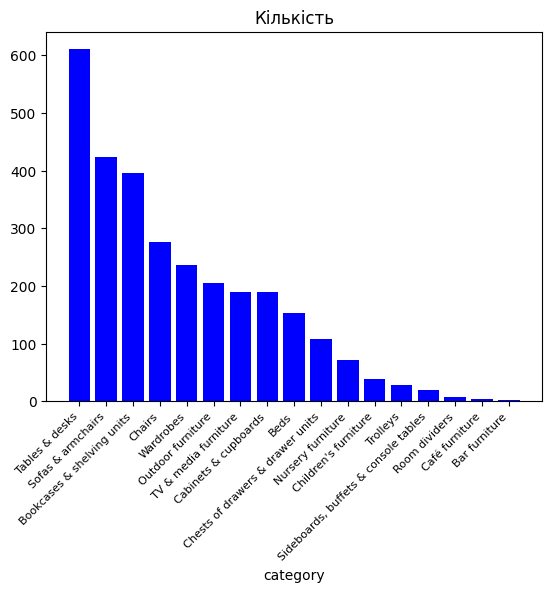

In [127]:
sorted_data = data['category'].value_counts().sort_values(ascending=False)
plt.bar(sorted_data.index, sorted_data, color='blue')
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.xlabel('category')
plt.title('Кількість')
plt.show()


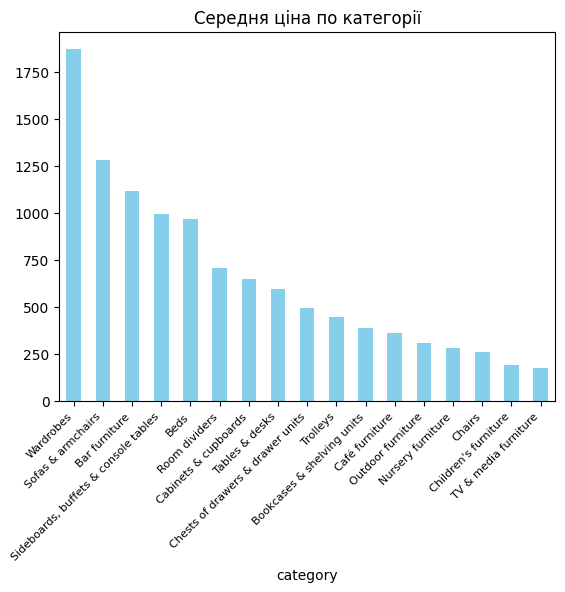

In [128]:
'''
Медіанна ціна по категорії
'''
average_prices = data.groupby('category')['price'].median().sort_values(ascending=False)
average_prices.plot(kind='bar', color='skyblue')
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.xlabel('category')
plt.title('Середня ціна по категорії')
plt.show()

<Axes: xlabel='category', ylabel='price'>

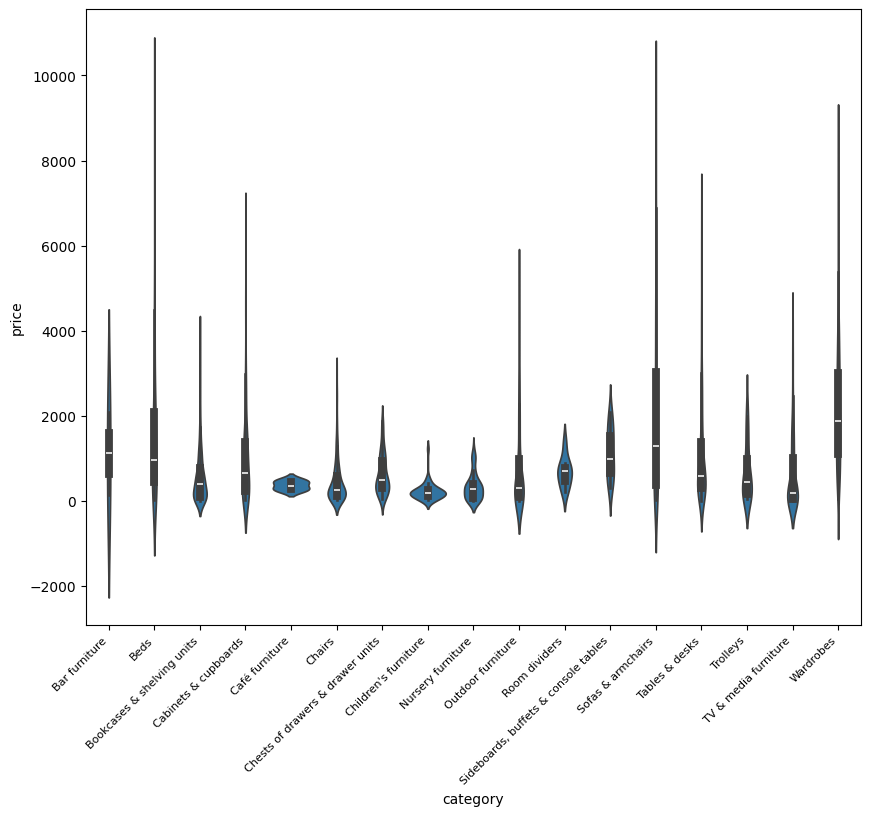

In [129]:
plt.subplots(figsize = (10,8))
plt.xticks(rotation=45, ha="right", fontsize=8)
sns.violinplot(data= data, x = 'category', y = 'price')

In [130]:
'''
Найбільші викиди ціни у катеоріях Wardrobes, Sofa & armchairs - що і пояснює їх високу медіанна ціну
Категорії Childrens furniture, Nursery furniture, Cafe furniture є найбільш збалансованими, і мають найменшу середню ціну
'''

'\nНайбільші викиди ціни у катеоріях Wardrobes, Sofa & armchairs - що і пояснює їх високу медіанна ціну\nКатегорії Childrens furniture, Nursery furniture, Cafe furniture є найбільш збалансованими, і мають найменшу середню ціну\n'

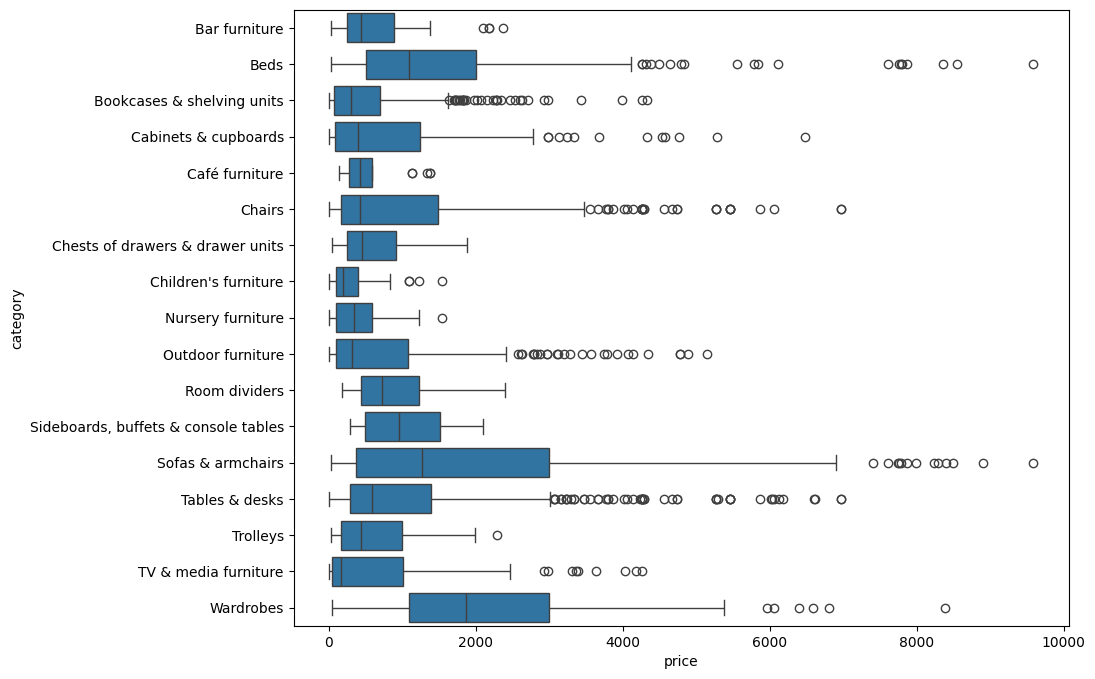

In [131]:
plt.subplots(figsize = (10,8))
sns.boxplot(data = df_ikea, x = 'price', y = 'category')
plt.show()

C:\Users\Analytic\AppData\Local\Temp\ipykernel_9904\2974853413.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['price'], bins=10)


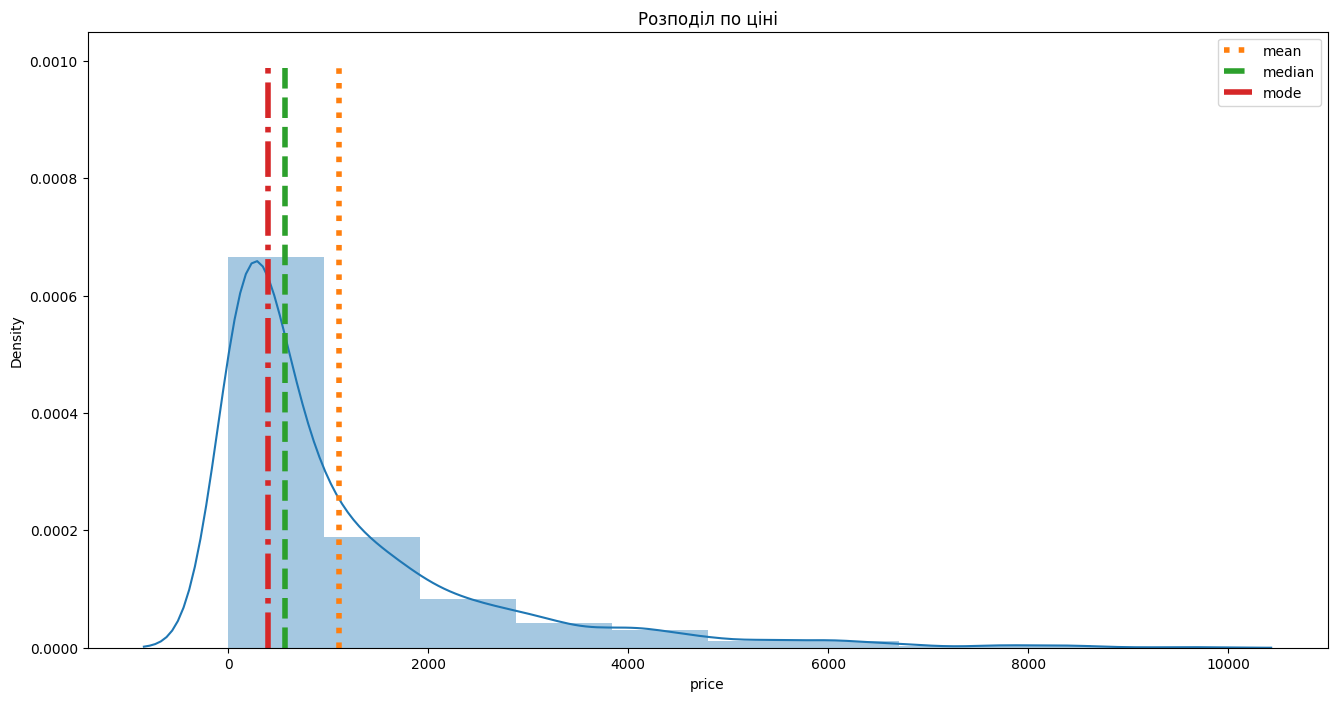

In [132]:
'''
Приблизно половина меблів мають ціну меншу 500, при цьому середня ціна становить близько 1100
'''
target_mean = round(data['price'].mean(), 2)
target_median = data['price'].median()
target_mode = data['price'].mode()[0]

plt.figure(figsize=(16,8))
sns.distplot(data['price'], bins=10)
plt.title('Розподіл по ціні')

y=np.linspace(0, 0.001, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Розподіл по ціні')
plt.legend()
plt.show()



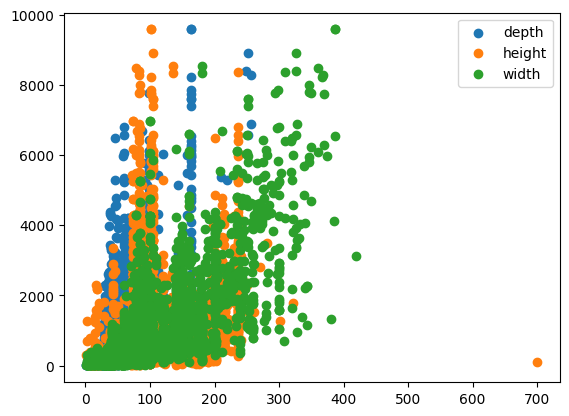

In [133]:
'''
Аналізуючи залежність ціни від розмірів можна побачити, що найбільша залежність ціни від довжини і хітмап це підтверждує
'''
plt.scatter(x=data['depth'], y=data['price'])
plt.scatter(x=data['height'], y=data['price'])
plt.scatter(x=data['width'], y=data['price'])
plt.legend(labels=['depth', 'height','width'])

<Axes: >

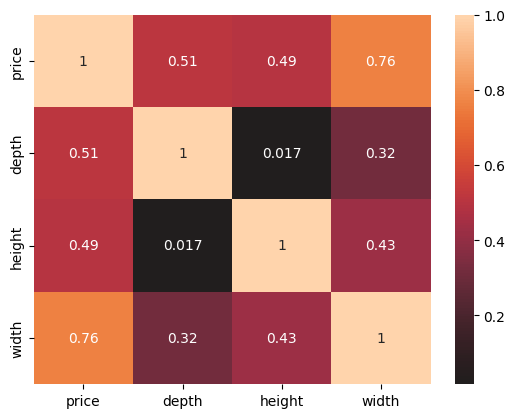

In [134]:
sns.heatmap(data[['price', 'depth', 'height', 'width']].corr(method= 'spearman'), xticklabels= data[['price', 'depth', 'height', 'width']].corr().columns, yticklabels= data[['price', 'depth', 'height', 'width']].corr().columns, center= 0, annot= True)

In [135]:
'''
Додамо стовпець об'ем меблів и розглянемо залежність ціни від об'ему
Бачимо, що залежність не велика 0,64
'''
for index, row in data.iterrows():
    if pd.isnull(row['depth']) and pd.isnull(row['height']) and pd.isnull(row['width']):
        # Если значения в столбцах "depth", "height", "width" равны NaN, устанавливаем значение "area" равным 1
        data.at[index, 'volume'] = np.nan
    elif pd.notna(row['depth']) and pd.isnull(row['height']) and pd.notna(row['width']):
        data.at[index, 'volume']=data.at[index,'depth']*data.at[index,'width']
    elif pd.isnull(row['depth']) and pd.notna(row['height']) and pd.notna(row['width']):
        data.at[index, 'volume']=data.at[index,'height']*data.at[index,'width']
    elif pd.notna(row['depth']) and pd.notna(row['height']) and pd.isnull(row['width']):
        data.at[index, 'volume']=data.at[index,'height']*data.at[index,'depth']
    elif pd.notna(row['depth']) and pd.isnull(row['height']) and pd.isnull(row['width']):
        data.at[index, 'volume']=data.at[index,'depth']
    elif pd.isnull(row['depth']) and pd.notna(row['height']) and pd.isnull(row['width']):
        data.at[index, 'volume']=data.at[index,'height']
    elif pd.isnull(row['depth']) and pd.isnull(row['height']) and pd.notna(row['width']):
        data.at[index, 'volume']=data.at[index,'width']
    else: data.at[index, 'volume']=data.at[index,'width']*data.at[index,'height']*data.at[index,'depth']
data.head()

,item_id,name,category,price,sellable_online,link,other_colors,short_description,designer,depth,height,width,volume
0,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN,NaN
1,50363649,KULLABERG,Bar furniture,140.0,True,https://www.ikea.com/sa/en/p/kullaberg-stool-b...,Yes,Stool,Sarah Fager,36.0,NaN,36.0,1296.0
2,29123958,MINNEN,Beds,395.0,True,https://www.ikea.com/sa/en/p/minnen-ext-bed-fr...,No,"Ext bed frame with slatted bed base, ...",IKEA of Sweden/Tina Christensen,NaN,NaN,85.0,85.0
3,49278341,BRIMNES,Beds,895.0,True,https://www.ikea.com/sa/en/p/brimnes-bed-frame...,No,"Bed frame w storage and headboard, ...",IKEA of Sweden/K Hagberg/M Hagberg,54.0,110.0,96.0,570240.0
4,89326463,PLATSA,Beds,2111.0,True,https://www.ikea.com/sa/en/p/platsa-bed-frame-...,No,"Bed frame with 4 drawers, 140...",Ola Wihlborg/IKEA of Sweden,40.0,43.0,140.0,240800.0


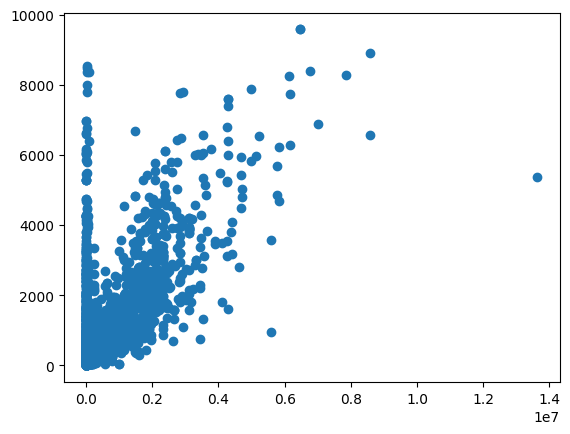

In [136]:
plt.scatter(x=data['volume'], y=data['price'])

In [137]:
numeric_columns = ['price', 'volume']
numeric_data = data[numeric_columns]

# Створюємо корреляційну матрицю
print(numeric_data.corr())


           price    volume
price   1.000000  0.643811
volume  0.643811  1.000000


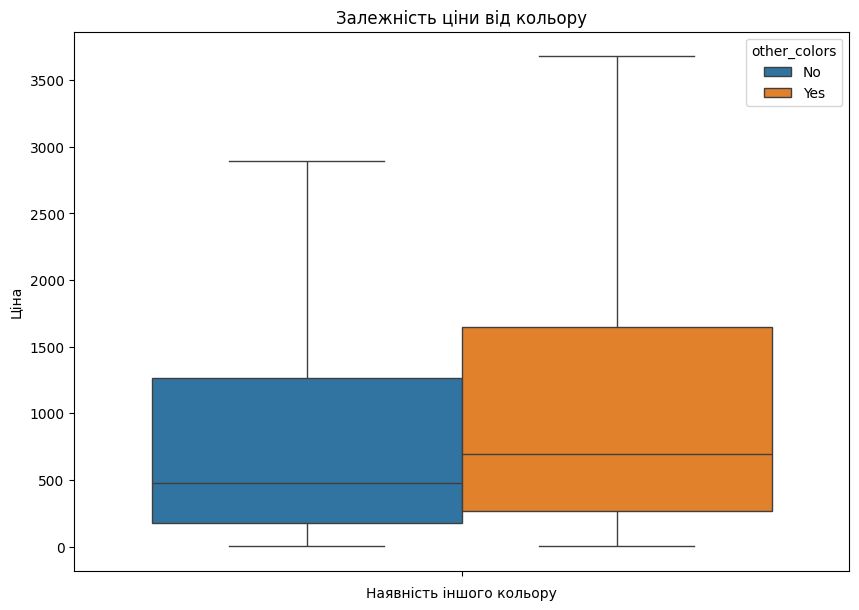

In [138]:
'''
Проаналізуємо залежність ціни від кольору за допомогою ящику з вусами
Можна зробити висновок, що товари, які мають декілька кольорів, коштують дорожче і медіана ціни в них більша
'''

plt.figure(figsize=(10,7))
sns.boxplot(data = data, hue = 'other_colors', y = 'price', showfliers=False)
plt.title('Залежність ціни від кольору')
plt.xlabel('Наявність іншого кольору')
plt.ylabel('Ціна')

plt.show()

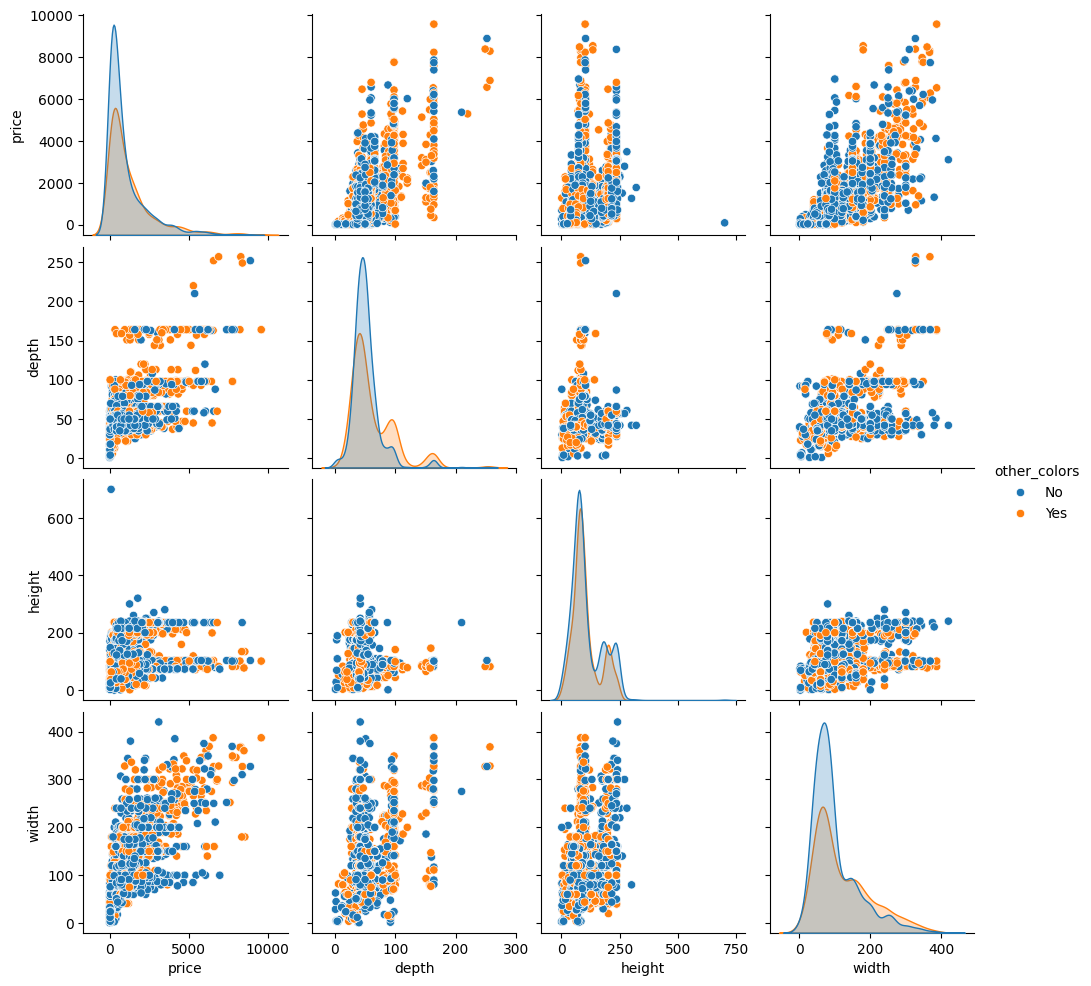

In [139]:
'''
Залежність ціни та розмірів від наявності двох і більше кольорів продемостровано на графіках нижче
'''
sns.pairplot(data[['price', 'depth', 'height', 'width', 'other_colors', 'category']], hue = 'other_colors')

In [140]:
'''
Проаналізуємо залежність ціни від виробника
Візьмемо виробників, які мають більше 20 виробів
'''
value_by_name=data.groupby("name")['price'].agg(["count", "max", "mean", "median"]).sort_values('count', ascending=False)
print(value_by_name[value_by_name['count'] >= 20])
print(value_by_name[value_by_name['count'] >= 20].sort_values('max', ascending=False))
print(value_by_name[value_by_name['count'] >= 20].sort_values('mean', ascending=False))

                 count     max         mean  median
name                                               
BESTÅ              115  4260.0  1008.400000   920.0
PAX                111  8380.0  2795.342342  2690.0
GRÖNLID             82  8900.0  2529.939024  1605.0
IVAR                66  2275.0   683.954545   590.0
BEKANT              64  6614.0  1934.703125  1274.5
VIMLE               60  8395.0  2257.166667  1657.5
EKET                58  2020.0   456.224138   266.5
PLATSA              57  3493.0  1489.535088  1560.0
LIDHULT             48  9585.0  3583.395833  3124.0
NORDLI              46  2290.0   932.282609   940.0
HAVSTA              40  4770.0  1673.125000  1467.5
TROFAST             40   475.0   194.000000   195.0
JONAXEL             39   990.0   366.538462   195.0
ELVARLI             37  4128.0  1566.783784  1495.0
HEMNES              37  3986.0  1292.283784   995.0
ALGOT               36   594.0   250.233333   239.5
VALLENTUNA          34  7988.0  2574.705882  2124.0
ÄPPLARÖ     

In [141]:
'''
Найбільша кількість меблів у виробника BESTÅ.
Найдорожчі речі у виробника LIDHULT. 
'''

'\nНайбільша кількість меблів у виробника BESTÅ.\nНайдорожчі речі у виробника LIDHULT. \n'

<Axes: xlabel='name'>

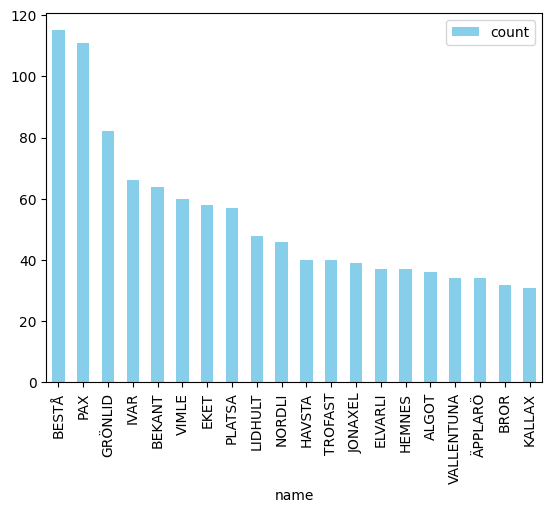

In [142]:
'''
Кількість виробів по виробнику
'''
names = data.groupby('name')['price'].agg(["count"]).sort_values('count', ascending=False)
names=names.iloc[:20]
names.plot(kind='bar', color='skyblue')



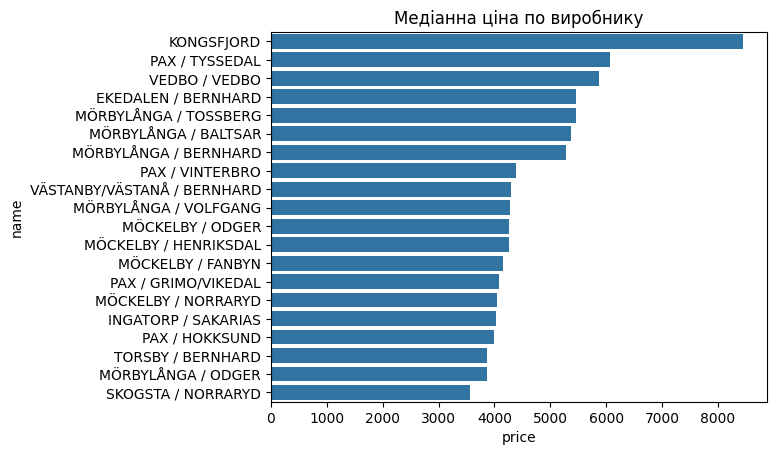

In [143]:
'''
Медіанна ціна по виробнику
'''
average_prices_by_name = data.groupby('name')['price'].median().reset_index()
average_prices_by_name = average_prices_by_name.sort_values('price', ascending=False).reset_index(drop=True)
average_prices_by_name = average_prices_by_name.iloc[:20]

sns.barplot(x="price", y="name", data=average_prices_by_name, orient='horizontal')
plt.title('Медіанна ціна по виробнику')
plt.show()

In [144]:
'''
Проаналізуємо дані по дизайнерам
'''
counts_by_designer = data.groupby("designer")["price"].agg(["count"]).reset_index()
counts_by_designer = counts_by_designer[counts_by_designer['count']>= 20].sort_values('count', ascending=False).reset_index(drop=True)
print(counts_by_designer)

                          designer  count
0                   IKEA of Sweden    683
1                  Ehlén Johansson    136
2                Francis Cayouette    131
3                     Ola Wihlborg    128
4                     Jon Karlsson    106
5              K Hagberg/M Hagberg     98
6   Ehlén Johansson/IKEA of Sweden     70
7   IKEA of Sweden/Ehlén Johansson     68
8                    Henrik Preutz     64
9                     Carina Bengs     60
10   K Malmvall/E Lilja Löwenhielm     55
11                   Nike Karlsson     43
12                 Ebba Strandmark     42
13            Eva Lilja Löwenhielm     41
14               Studio Copenhagen     35
15          H Preutz/A Fredriksson     30
16                     Johan Kroon     27
17                      David Wahl     26
18                  Tord Björklund     26
19                    Mia Lagerman     25
20     IKEA of Sweden/Jon Karlsson     25
21                  Marcus Arvonen     21
22     Jon Karlsson/IKEA of Sweden

<BarContainer object of 24 artists>

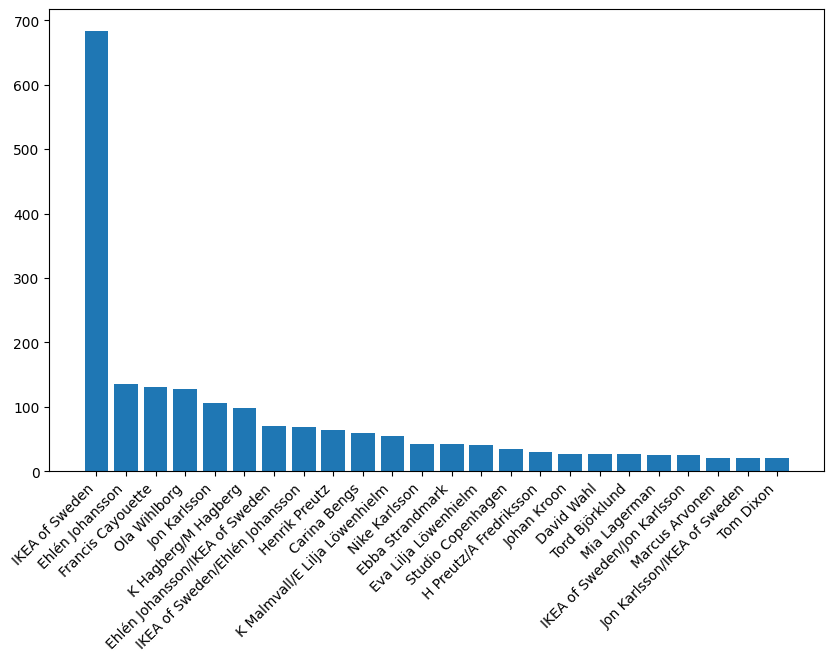

In [145]:
'''
Кількість по дизайнерам
'''
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.bar(counts_by_designer['designer'], counts_by_designer['count'])

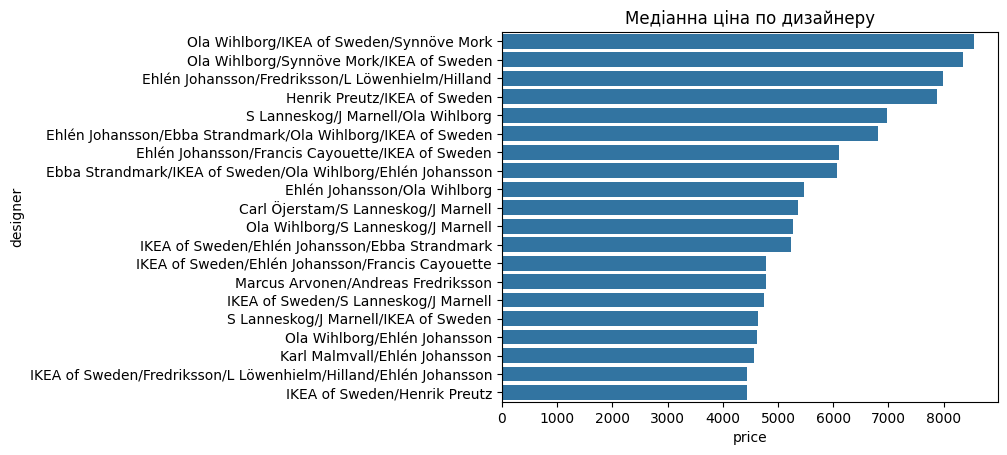

In [146]:
'''
Медіанна ціна по дизайнеру
'''
average_prices_by_des = data.groupby('designer')['price'].median().reset_index()
average_prices_by_des = average_prices_by_des.sort_values('price', ascending=False).reset_index(drop=True)
average_prices_by_des = average_prices_by_des.iloc[:20]

sns.barplot(x="price", y="designer", data=average_prices_by_des, orient='horizontal')
plt.title('Медіанна ціна по дизайнеру')
plt.show()

In [147]:
#Step 2 - Machine Learning
'''
Замінемо нерелевантні значення дизайнерів на None
'''
digit_mask = data['designer'].str.contains('\d')
analysis_data = data[~digit_mask].reset_index(drop=True)


analysis_data['designer'].count()


2860

In [148]:
'''
Підготуємо дані до машинного навчання
'''
analysis_data['sellable_online']=analysis_data['sellable_online'].replace({True: 1, False: 0})
analysis_data['other_colors']=analysis_data['other_colors'].replace({'Yes': 1, 'No': 0})
exclude_cols = ['item_id', 'price']
num_cols = ['depth', 'height', 'width', 'sellable_online', 'other_colors']
cat_cols = ['name', 'category', 'designer', 'link', 'short_description']
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])
analysis_data1=analysis_data.drop(exclude_cols, axis=1)
X_train, X_test, y_train, y_test = train_test_split(analysis_data1, analysis_data['price'], test_size=0.2, random_state=42)



In [149]:
#додамо запис логування при запуску моделей

import logging 
import time 

logging.basicConfig(filename = 'machine_learning_traning.log', filemode= 'w', level= logging.INFO, format= '%(asctime)s - %(levelname)s - %(message)s')
def start_pipeline(pipeline, X_train, Y_train, X_test, Y_test, type_of_fillin) -> None: 
    logging.info('Start model traning')
    pipeline.fit(X_train, Y_train)
    logging.info(f'Model: {pipeline[1]} Accuracy: {str(pipeline.score(X_test, Y_test))}. Type of prepros: {type_of_fillin}' )

In [150]:
# 1) KNeighborsRegressor
model_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn_regressor', KNeighborsRegressor())
])

model_knn.fit(X_train, y_train)
y_knn_pred = model_knn.predict(X_test)
''' Оценим производительность модели:
'''
print('R^2 : {:.5f}'.format(model_knn.score(X_test, y_test)))
print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(y_knn_pred, y_test)))
print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(y_knn_pred, y_test))))

R^2 : 0.79480
MAE : 351.79895
MSE : 582.53625


In [151]:
start_pipeline(model_knn, X_train, y_train, X_test, y_test, 'Fill in manual')

In [152]:
# 2) LinearRegression
LR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('LR_regressor', LinearRegression())
])
LR.fit(X_train, y_train)
LR_pred = LR.predict(X_test)
print('R^2 : {:.5f}'.format(LR.score(X_test, y_test)))
print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(LR_pred, y_test)))
print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(LR_pred, y_test))))

R^2 : 0.78995
MAE : 387.96136
MSE : 589.38577


In [153]:
start_pipeline(LR, X_train, y_train, X_test, y_test, 'Fill in manual')

In [154]:
# 3) DecisionTreeRegressor
dtr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('DTR_regressor', DecisionTreeRegressor(random_state=42))
])
dtr.fit(X_train, y_train)
dtr_pred = dtr.predict(X_test)
print('R^2 : {:.5f}'.format(dtr.score(X_test, y_test)))
print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(dtr_pred, y_test)))
print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(dtr_pred, y_test))))

R^2 : 0.72535
MAE : 365.15507
MSE : 673.93846


In [155]:
start_pipeline(dtr, X_train, y_train, X_test, y_test, 'Fill in manual')

In [156]:
# 4) RandomForestRegressor
rfr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfс_regressor', RandomForestRegressor(random_state=42))
])
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)

print('R^2 : {:.5f}'.format(rfr.score(X_test, y_test)))
print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(rfr_pred, y_test)))
print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(rfr_pred, y_test))))


R^2 : 0.80853
MAE : 310.41136
MSE : 562.71026


In [157]:
start_pipeline(rfr, X_train, y_train, X_test, y_test, 'Fill in manual')

In [158]:
#5) Ridge
alphas = [0.1, 1.0, 10.0, 100.0]
ridge_scores = []
for alpha in alphas:
    ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=alpha))])
# Fit the data
    ridge.fit(X_train, y_train)

    score = ridge.score(X_test, y_test)
    ridge_scores.append(score)
print(ridge_scores)

[0.7891020190330628, 0.781205492544903, 0.7346940784666889, 0.6624239525092135]


In [159]:
start_pipeline(ridge, X_train, y_train, X_test, y_test, 'Fill in manual')

In [160]:
#6) Lasso
alphas = [0.1, 1.0, 10.0, 100.0]
lasso_scores = []
for alpha in alphas:
    lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Lasso(alpha=alpha))])
# Fit the data
    lasso.fit(X_train, y_train)

    score = lasso.score(X_test, y_test)
    lasso_scores.append(score)
print(lasso_scores)

[0.7623232379462271, 0.7547855520523343, 0.6348785169625011, 0.5611325214352826]


In [161]:
start_pipeline(lasso, X_train, y_train, X_test, y_test, 'Fill in manual')

In [162]:
#налаштування гіперпараметрів для DTR_regressor
dtr_param_grid = {
    'DTR_regressor__max_depth': [5, 10, 15, 20, None],
    'DTR_regressor__min_samples_split': [3, 6, 8, 12],
    'DTR_regressor__min_samples_leaf': [6, 8, 11, 15]
}
dtr_gs = GridSearchCV(dtr, dtr_param_grid, cv=5)
dtr_gs.fit(X_train, y_train)
print(f"Decision Tree: best parameters {dtr_gs.best_params_}, best score {dtr_gs.best_score_}")


Decision Tree: best parameters {'DTR_regressor__max_depth': 20, 'DTR_regressor__min_samples_leaf': 6, 'DTR_regressor__min_samples_split': 3}, best score 0.7100848420808759


In [163]:
# DecisionTreeRegressor з налаштованними гіперпараметрами
best_params = {
'max_depth': 20,
'min_samples_leaf': 6,
'min_samples_split': 3,
'splitter': 'best'
}
dtr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('DTR_regressor', DecisionTreeRegressor(random_state=42, **best_params))
])
dtr.fit(X_train, y_train)
dtr_pred = dtr.predict(X_test)
print('R^2 : {:.5f}'.format(dtr.score(X_test, y_test)))
print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(dtr_pred, y_test)))
print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(dtr_pred, y_test))))


R^2 : 0.71067
MAE : 405.45556
MSE : 691.71680


In [164]:
# KNeighborsRegressor з налаштованними гіперпараметрами
knn_param_grid = {'knn_regressor__n_neighbors': [i for i in range(1, 16)], 'knn_regressor__weights': ['uniform', 'distance']}
knn_gs = GridSearchCV(model_knn, knn_param_grid, cv=5)
knn_gs.fit(X_train, y_train)
print(f"KNN: best parameters {knn_gs.best_params_}, best score {knn_gs.best_score_}")

KNN: best parameters {'knn_regressor__n_neighbors': 4, 'knn_regressor__weights': 'distance'}, best score 0.7708618367025162


In [165]:
best_params = {
'n_neighbors': 4,
'weights': 'distance'
}
model_knr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn_regressor', KNeighborsRegressor(**best_params))
])

model_knr.fit(X_train, y_train)
y_knn_pred = model_knr.predict(X_test)
''' Оценим производительность модели:
'''
print('R^2 : {:.5f}'.format(model_knr.score(X_test, y_test)))
print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(y_knn_pred, y_test)))
print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(y_knn_pred, y_test))))

R^2 : 0.80685
MAE : 337.07019
MSE : 565.17536


In [166]:
# RandomForestRegressor з налаштованними гіперпараметрами
rfc_param_grid = {
    'rfс_regressor__n_estimators': [3, 7, 10],
    'rfс_regressor__max_depth': [None, 4, 8],
    'rfс_regressor__min_samples_split': [2, 5, 10],
    'rfс_regressor__min_samples_leaf': [1, 2, 4]
}

rfc_gs = GridSearchCV(rfr, rfc_param_grid, cv=5)

rfc_gs.fit(X_train, y_train)

print(f"Random Forest: best parameters {rfc_gs.best_params_}, best score {rfc_gs.best_score_}")


Random Forest: best parameters {'rfс_regressor__max_depth': None, 'rfс_regressor__min_samples_leaf': 2, 'rfс_regressor__min_samples_split': 2, 'rfс_regressor__n_estimators': 10}, best score 0.798304377799338


In [167]:
best_params = {
'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 7
}
rfr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfс_regressor', RandomForestRegressor(random_state=42, **best_params))
])
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)

print('R^2 : {:.5f}'.format(rfr.score(X_test, y_test)))
print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(rfr_pred, y_test)))
print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(rfr_pred, y_test))))

R^2 : 0.79096
MAE : 337.28953
MSE : 587.96293


In [227]:
# Визначення найкращої моделі
def getBestRegressor (X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    models = [
        LinearRegression(),
        Lasso(),
        Ridge(),
        KNeighborsRegressor(n_neighbors=4, weights='distance'),
        DecisionTreeRegressor(random_state=42, max_depth=20, min_samples_leaf=6, min_samples_split=3, splitter='best'),
        RandomForestRegressor(random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=7),
        GradientBoostingRegressor()
    ]
    
    TestModels = pd.DataFrame()
    res = {}
    tmp = {}
    
    for model in models:
        m = str(model)
        tmp['Model'] = m[:m.index('(')]
        top_model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('rfс_regressor', model)
        ])
        top_model.fit(X_train, y_train)
        tmp['R^2'] = '{:.5f}'.format(top_model.score(X_test, y_test))
        tmp['MAE'] = '{:.5f}'.format(sk.metrics.mean_absolute_error(top_model.predict(X_test), y_test))
        tmp['RMSE'] = '{:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(top_model.predict(X_test), y_test)))
        TestModels = pd.concat([TestModels, pd.DataFrame([tmp])])
        
    #TestModels.set_index('Model', inplace=True)
    return TestModels

In [228]:
print(getBestRegressor(analysis_data1, analysis_data['price']))

                       Model      R^2        MAE       RMSE
0           LinearRegression  0.78995  387.96136  589.38577
0                      Lasso  0.75479  433.50696  636.80461
0                      Ridge  0.78121  401.71763  601.52181
0        KNeighborsRegressor  0.80685  337.07019  565.17536
0      DecisionTreeRegressor  0.71067  405.45556  691.71680
0      RandomForestRegressor  0.79096  337.28953  587.96293
0  GradientBoostingRegressor  0.75954  413.34838  630.60333


C:\Users\Analytic\AppData\Local\Temp\ipykernel_9904\476421978.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.index, y='R^2', data=df, palette='viridis')
C:\Users\Analytic\AppData\Local\Temp\ipykernel_9904\476421978.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.index, y='MAE', data=df, palette='plasma')
C:\Users\Analytic\AppData\Local\Temp\ipykernel_9904\476421978.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.index, y='RMSE', data=df, palette='magma')


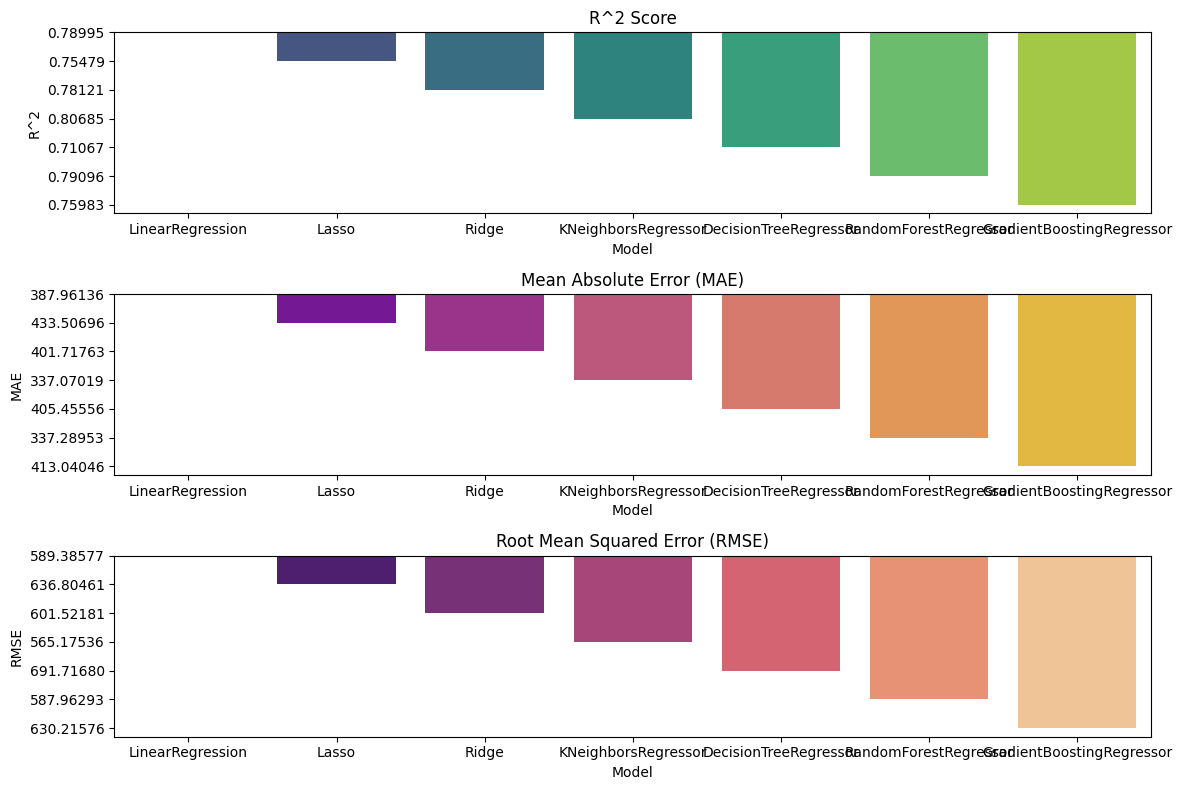

In [242]:
df = pd.DataFrame(getBestRegressor(analysis_data1, analysis_data['price']))

df.set_index('Model', inplace=True)

# Построим графики
plt.figure(figsize=(12, 8))

# График R^2
plt.subplot(3, 1, 1)
sns.barplot(x=df.index, y='R^2', data=df, palette='viridis')
plt.title('R^2 Score')

# График MAE
plt.subplot(3, 1, 2)
sns.barplot(x=df.index, y='MAE', data=df, palette='plasma')
plt.title('Mean Absolute Error (MAE)')

# График RMSE
plt.subplot(3, 1, 3)
sns.barplot(x=df.index, y='RMSE', data=df, palette='magma')
plt.title('Root Mean Squared Error (RMSE)')

plt.tight_layout()
plt.show()

C:\Users\Analytic\AppData\Local\Temp\ipykernel_9904\3664274772.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R^2', y=df.index, data=df, palette='viridis')
C:\Users\Analytic\AppData\Local\Temp\ipykernel_9904\3664274772.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAE', y=df.index, data=df, palette='plasma')
C:\Users\Analytic\AppData\Local\Temp\ipykernel_9904\3664274772.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y=df.index, data=df, palette='magma')


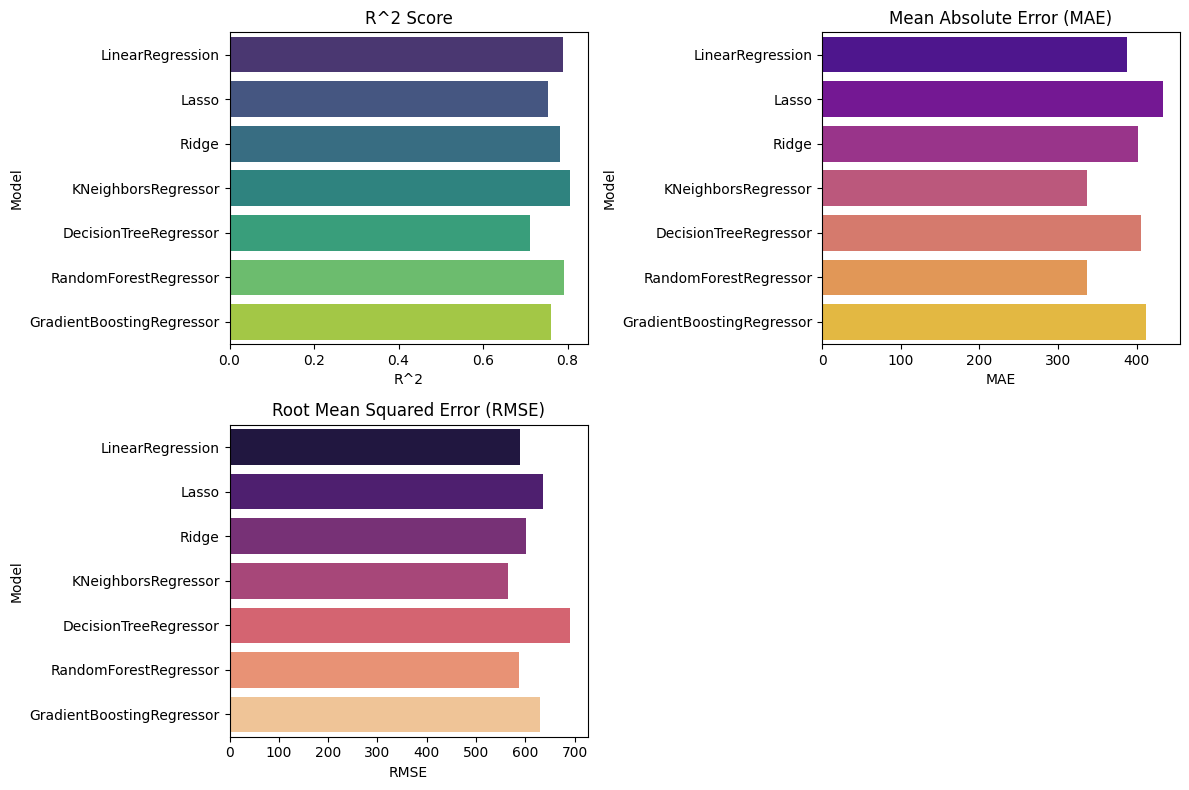

In [203]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Фиктивные данные
data = {
    'Model': ['LinearRegression', 'Lasso', 'Ridge', 'KNeighborsRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor'],
    'R^2': [0.78995, 0.75479, 0.78121, 0.80685, 0.71067, 0.79096, 0.76026],
    'MAE': [387.96136, 433.50696, 401.71763, 337.07019, 405.45556, 337.28953, 412.37159],
    'RMSE': [589.38577, 636.80461, 601.52181, 565.17536, 691.71680, 587.96293, 629.65702]
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)

# Построение графиков
plt.figure(figsize=(12, 8))

# График R^2
plt.subplot(2, 2, 1)
sns.barplot(x='R^2', y=df.index, data=df, palette='viridis')
plt.title('R^2 Score')

# График MAE
plt.subplot(2, 2, 2)
sns.barplot(x='MAE', y=df.index, data=df, palette='plasma')
plt.title('Mean Absolute Error (MAE)')

# График RMSE
plt.subplot(2, 2, 3)
sns.barplot(x='RMSE', y=df.index, data=df, palette='magma')
plt.title('Root Mean Squared Error (RMSE)')

plt.tight_layout()
plt.show()


In [ ]:
''' Найкращі результати показали моделі KNeighborsRegressor, RandomForestRegressor та LinearRegression
з найнижчими показниками RMSE и MAE. 
Проведемо кросс-валідацію цих моделей'''

In [ ]:
# 1) Кросс-валідація KNeighborsRegressor
cv_knr = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse_scores_knr = cross_val_score(model_knr, analysis_data.drop(exclude_cols, axis=1), analysis_data['price'], cv=cv_knr, scoring='neg_mean_squared_error')
mse_scores_knr = -neg_mse_scores_knr

print('RMSE: {:.2f}'.format(np.sqrt(mse_scores_knr.mean())))
print('MSE: {:.2f}'.format(mse_scores_knr.mean()))



RMSE: 649.79
MSE: 422222.10


In [ ]:
# 2) Кросс-валідація LinearRegression
cv_lr = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse_scores_lr = cross_val_score(LR, analysis_data.drop(exclude_cols, axis=1), analysis_data['price'], cv=cv_lr, scoring='neg_mean_squared_error')
mse_scores_lr = -neg_mse_scores_lr

print('RMSE: {:.2f}'.format(np.sqrt(mse_scores_lr.mean())))
print('MSE: {:.2f}'.format(mse_scores_lr.mean()))


RMSE: 638.21
MSE: 407309.20


In [ ]:
# 3) Кросс-валідація RandomForestRegressor
cv_rfr = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse_scores_rfr = cross_val_score(rfr, analysis_data.drop(exclude_cols, axis=1), analysis_data['price'], cv=cv_rfr, scoring='neg_mean_squared_error')
mse_scores_rfr = -neg_mse_scores_rfr

print('RMSE: {:.2f}'.format(np.sqrt(mse_scores_rfr.mean())))
print('MSE: {:.2f}'.format(mse_scores_rfr.mean()))


RMSE: 644.61
MSE: 415518.21


In [ ]:
'''
Провівши кросс-валідацію трьох кращих моделей і оцінивши результати, можно зробити висновок, що найкраще себе показала модель лінійної регресії з результатом
RMSE: 638
MSE: 407309 
'''

In [ ]:
'''
Проаналізувавши декілька моделей, можно зробити висновки, що все ж це досить великі помилки в данному випадку, тому використання моделей в такому вигляді - непрактичне. 
Для підвищення точності оцінки моделі можно застосувати фіча інжиниринг - збільшити кількість стовпців у датафреймі, наприклад перевести у формат 0, 1 стовпець із дизайнерами.
Щоб модель корректно зчитувала, якому дизайнеру належить виріб
Також треба спробувати заповнити корректно всі значення дизайнерів.
А ще моделі можна додати стовпці

1) розмір пакування
2) кількість кольорів
3) рік випуску
4) матеріал, з якого виготовлено меблі
5) гарантійний строк мебелів
'''

'\nПроаналізувавши 6 моделей, та налаштувавши їх за допомогою гіперпараметрів, можна зробити висновок, що найкраще себе показала модель KNeighborsRegressor\nз оцінкою 0,806 та середньою помилкою 334. Найгірше себе показала модель DecisionTreeRegressor з оцінкою 0,71. Модель Lasso має середню оцінку серед моделей, \nале найбільшу помилку прогнозу ціни - 433.\nТа все ж це досить великі помилки в данному випадку, тому використання моделей в такому вигляді - непрактичне. \nДля підвищення точності оцінки моделі можно застосувати фіча інжиниринг - збільшити кількість стовпців у датафреймі, наприклад перевести у формат 0, 1 стовпець із дизайнерами.\nЩоб модель корректно зчитувала, якому дизайнеру належить виріб\nТакож треба спробувати заповнити корректно всі значення дизайнерів.\nА ще моделі можна додати стовпці\n\n1) розмір пакування\n2) кількість кольорів\n3) рік випуску\n4) матеріал, з якого виготовлено меблі\n5) гарантійний строк мебелів\n'